In [1]:
# ------------------------------------------------------
#
# Plot iCESM isotope field and spatial d18O gradient 
# data (figure 2, panels B-F)
# 
# ------------------------------------------------------
import os
import numpy as np
import xarray as xr
import math
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.integrate
from scipy.interpolate import griddata  # for re-gridding np arrays in tau-bar fxn
from matplotlib import gridspec
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
# for colors
import cmocean
import cmocean.cm as cmo
import seaborn as sns # used for discrete

In [2]:
# SAVE FIGURES ?  -------------------------------
figsave_on = False
saveHere = ""

# read in seasonal data --------------------------------------
datpath = "/DISTRIBUTE/data_and_analysis/iCESM_topotrack_seasonal"   # [CHANGE!] path to "results_2x2_topotrack_seasonal" directory
fnsuff = ["_ds_withDd18.nc", "_streamlines.csv"]
mos = ["djf", "jja", "ann_prWtd"]
prefx = "slice_"

# use just precip-weighted mean
this_slice = mos[2]

# ... any dataset
ds_open = prefx + this_slice + fnsuff[0]
ds = xr.open_dataset(os.path.join(datpath, ds_open))
ds = ds.expand_dims(dim='yr_slice')
# ... jja dataframe
df_open = prefx + this_slice + fnsuff[1]
df = pd.read_csv(os.path.join(datpath, df_open))
df['yr_slice'] = this_slice


In [3]:
ds

<xarray.Dataset>
Dimensions:               (yr_slice: 1, lat: 192, lon: 288)
Coordinates:
  * yr_slice              (yr_slice) <U9 'ann_prWtd'
  * lat                   (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                   (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables: (12/155)
    LANDFRAC              (yr_slice, lat, lon) float32 1.0 1.0 1.0 ... 0.0 0.0
    PRECC                 (yr_slice, lat, lon) float32 0.0 0.0 ... 9.787e-12
    PRECL                 (yr_slice, lat, lon) float32 2.527e-09 ... 8.555e-09
    PS                    (yr_slice, lat, lon) float32 6.765e+04 ... 1.012e+05
    QFLX                  (yr_slice, lat, lon) float32 -8.529e-08 ... 1.288e-06
    TMQ                   (yr_slice, lat, lon) float32 0.5176 0.5176 ... 7.201
    ...                    ...
    Dd18O_7500            (yr_slice, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    Dtopo_7500            (yr_slice, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    Dd18O_10000           (yr_slice, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    Dtopo_10000           (yr_slice, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    moisture_dist_inland  (yr_slice, lat, lon) float64 nan nan nan ... nan nan
    streamline_frac_land  (yr_slice, lat, lon) float64 nan nan nan ... nan nan

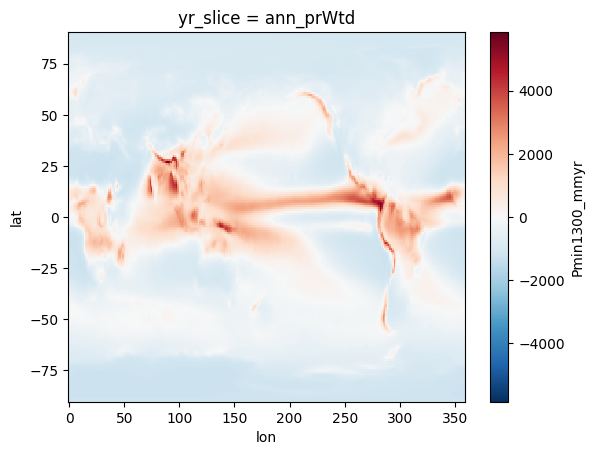

In [4]:
# --- convert P and E to mm/yr
# - p and e conversion factors 
# p: [m s-1 to mm yr-1]
pFac = 1000 * 86400 * 365
# e: [kg m-2 s-1 to mm yr-1]
eFac = 86400 * 365

# update das
ds['QFLX_mmyr'] = ds['QFLX'] * eFac
ds['PRECT_mmyr'] = ds['PRECT'] * pFac
ds['PminE_mmyr'] = ds['PRECT_mmyr'] - ds['QFLX_mmyr']
ds['Pmin1300_mmyr'] = ds['PRECT_mmyr'] - 1300

# ... quick check
ds['Pmin1300_mmyr'].plot();

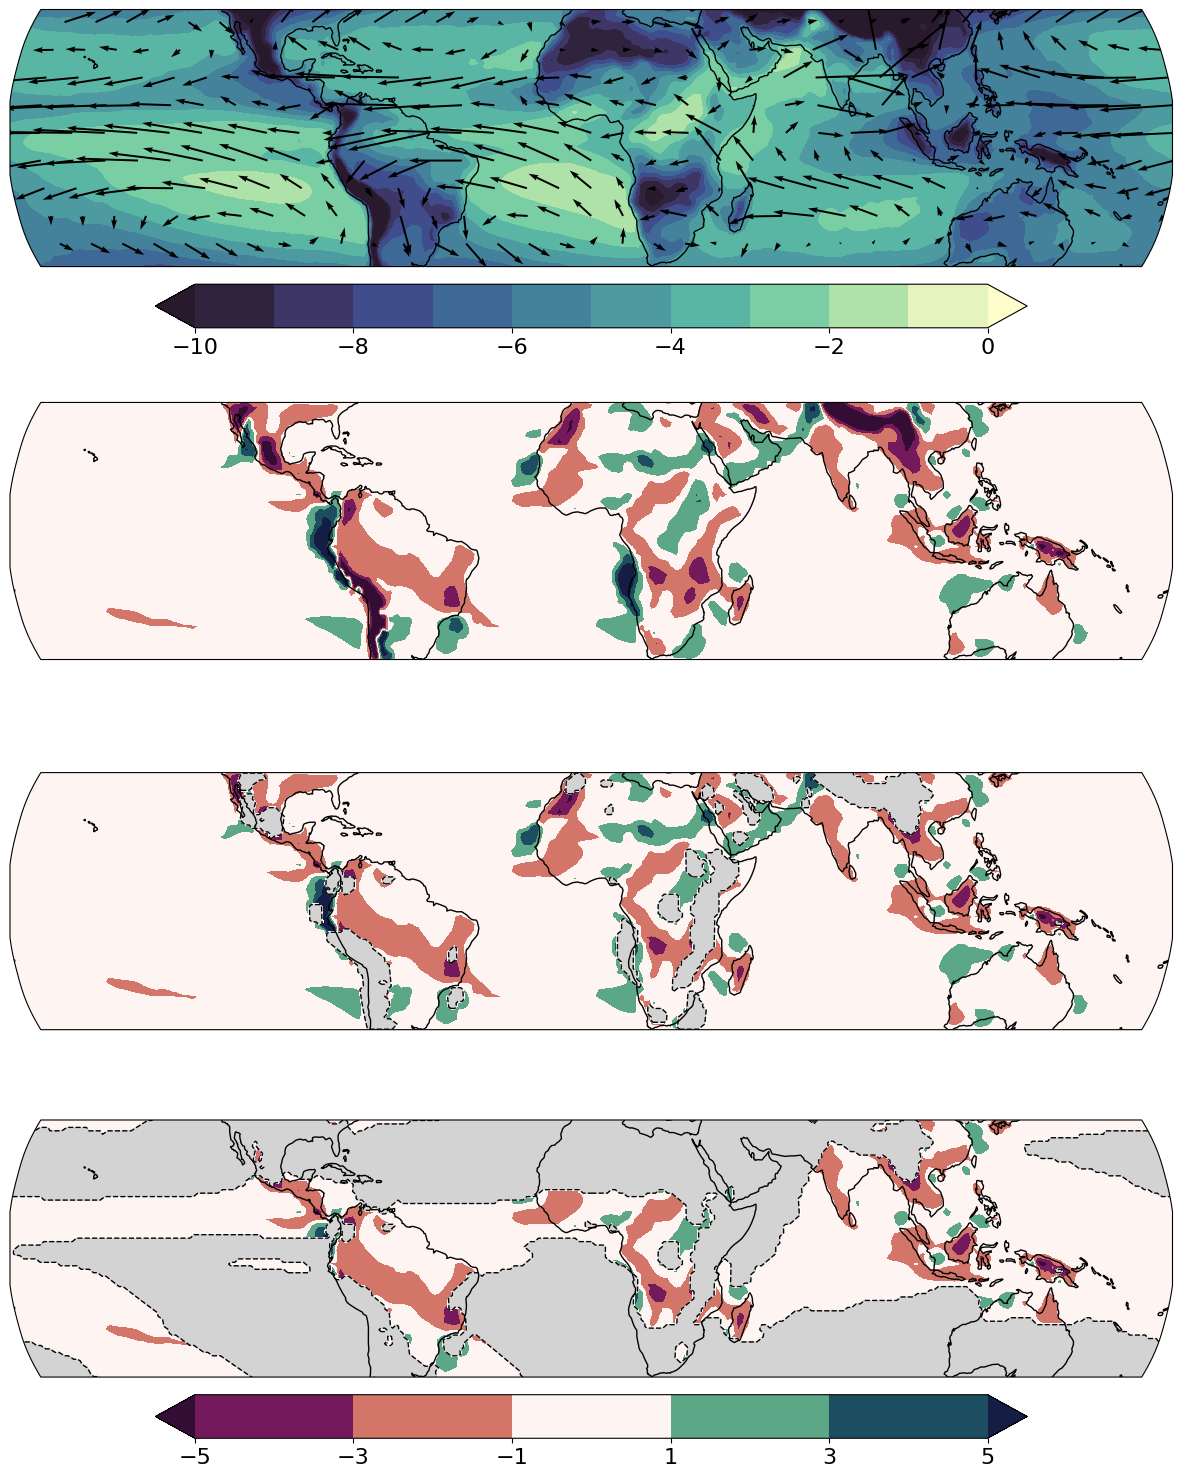

In [5]:
# MAP -- Dd18O
fname = "iCESM_d18O+gradients_maps.png"
# ... select colormap
mycmap = cmo.curl_r   # https://matplotlib.org/cmocean/
mycmap_d18 = cmo.deep_r

# ... select Dd18O range to consider
Dd18_var = "Dd18O_1000"
Dtopo_var = "Dtopo_1000"
# ... precip threshold
precip_threshold = 2.5e-8     # 2.5e-8 is ~770 mm/yr
pminPET1300_threshold = 0     # P - 1300 > 0 mm/yr
# ... set ylims
minlat, maxlat = -35, 35

# ... add cyclic point to remove bar at 0 lon
lon, lat = ds.sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2)).coords['lon'], ds.sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2)).coords['lat']
dsc, lonc = add_cyclic_point(ds.sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2))[Dd18_var], coord=lon)
dscd18, _ = add_cyclic_point(ds.sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2))['PRECT_d18O'], coord=lon)

# ... filter out topo 
# define hatching condition
hatch_above = 500
hatching_condition = np.abs(ds[Dtopo_var].sel(yr_slice=this_slice, lat=slice(minlat-2,maxlat+2))) > hatch_above
# remove
ds_filt = np.where(np.abs(ds[Dtopo_var].sel(yr_slice=this_slice, lat=slice(minlat-2,maxlat+2))) < hatch_above, ds[Dd18_var].sel(yr_slice=this_slice, lat=slice(minlat-2,maxlat+2)), np.nan)
dsc_filt, _ = add_cyclic_point(ds_filt, coord=lon)

# ... filter out low P
P_topo_condition = hatching_condition | (ds['Pmin1300_mmyr'].sel(yr_slice=this_slice, lat=slice(minlat-2,maxlat+2)) < pminPET1300_threshold)
ds_filtPtopo = np.where((ds['Pmin1300_mmyr'].sel(yr_slice=this_slice, lat=slice(minlat-2,maxlat+2)) > pminPET1300_threshold) & (ds[Dtopo_var].sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2)) < hatch_above), ds[Dd18_var].sel(yr_slice=this_slice, lat=slice(minlat-2,maxlat+2)), np.nan)
dsc_filtP, _ = add_cyclic_point(ds_filtPtopo, coord=lon)
P_topo_condition_c, _ = add_cyclic_point(P_topo_condition, coord=lon)

# ... set-up winds
add_winds_var = False
add_winds_var_d18 = True
# wind arrow parameters
wnd_scale = 0.5e4   # scale for arrow length
wnd_wd = 0.0017      # arrow width
wnd_dens = 8    # plot arrow every nth cell
lon_grid, lat_grid = np.meshgrid(lon,lat)
UQ_1, VQ_1 = ds['UQ'].sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2)).values, ds['VQ'].sel(yr_slice=this_slice, lat=slice(minlat-2, maxlat+2)).values


# colorbar properties
leg_shrink = 0.75    # [0-1]
leg_orient = "horizontal"
txtsize = 16



# set up grid for two panels
spec = gridspec.GridSpec(ncols=1, nrows=4, hspace=0.05)
plt.figure(figsize=(15,19))

# COLUMN 1 ---------------------------------
# TOP TOP TOP - JUST d18O ***** 
ax = plt.subplot(spec[0], projection=ccrs.Robinson())
plt.contourf(lonc, lat, dscd18, np.linspace(-10, 0, 11), 
             transform=ccrs.PlateCarree(), cmap=mycmap_d18, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
if add_winds_var_d18:
    ax.quiver(lon_grid[::wnd_dens, ::wnd_dens], lat_grid[::wnd_dens, ::wnd_dens], 
              UQ_1[::wnd_dens, ::wnd_dens], 
              VQ_1[::wnd_dens, ::wnd_dens],
            color='black', scale=wnd_scale, width=wnd_wd, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents


# TOP - ALL ***** 
ax = plt.subplot(spec[1], projection=ccrs.Robinson())
plt.contourf(lonc, lat, dsc, np.linspace(-5, 5, 6), 
             transform=ccrs.PlateCarree(), cmap=mycmap, extend='both') 
# cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
# cb.ax.tick_params(labelsize=txtsize)
if add_winds_var:
    ax.quiver(lon_grid[::wnd_dens, ::wnd_dens], lat_grid[::wnd_dens, ::wnd_dens], 
              UQ_1[::wnd_dens, ::wnd_dens], 
              VQ_1[::wnd_dens, ::wnd_dens],
            color='darkblue', scale=wnd_scale, width=wnd_wd, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# MIDDLE - ALL MINUS TOPO *****  
ax = plt.subplot(spec[2], projection=ccrs.Robinson())
plt.contourf(lonc, lat, dsc_filt, np.linspace(-5, 5, 6), 
             transform=ccrs.PlateCarree(), cmap=mycmap, extend='both') 
# cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
# cb.ax.tick_params(labelsize=txtsize)
# hatched outline
plt.contour(ds.sel(lat=slice(minlat-2,maxlat+2)).lon, ds.sel(lat=slice(minlat-2,maxlat+2)).lat, 
            hatching_condition, levels=[0.5], transform=ccrs.PlateCarree(),
            colors='k', linewidths=1, linestyles='dashed')
# gray fill
plt.contourf(ds.sel(lat=slice(minlat-2,maxlat+2)).lon, ds.sel(lat=slice(minlat-2,maxlat+2)).lat, 
            hatching_condition, levels=[0.5,1], transform=ccrs.PlateCarree(),
            colors='lightgray', linestyles='dashed')
if add_winds_var:
    ax.quiver(lon_grid[::wnd_dens, ::wnd_dens], lat_grid[::wnd_dens, ::wnd_dens], 
              UQ_1[::wnd_dens, ::wnd_dens], 
              VQ_1[::wnd_dens, ::wnd_dens],
            color='darkblue', scale=wnd_scale, width=wnd_wd, transform=ccrs.PlateCarree())
ax.coastlines() # add continents
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())

# BOTTOM - ALL MINUS TOPO AND DRY *****  
ax = plt.subplot(spec[3], projection=ccrs.Robinson())
plt.contourf(lonc, lat, dsc_filtP, np.linspace(-5, 5, 6), 
             transform=ccrs.PlateCarree(), cmap=mycmap, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
# hatched outline
plt.contour(lonc, lat, 
            P_topo_condition_c, levels=[0.5], transform=ccrs.PlateCarree(),
            colors='k', linewidths=1, linestyles='dashed')
# gray fill
plt.contourf(lonc, lat, 
            P_topo_condition_c, levels=[0.5,1], transform=ccrs.PlateCarree(),
            colors='lightgray', linestyles='dashed')
if add_winds_var:
    ax.quiver(lon_grid[::wnd_dens, ::wnd_dens], lat_grid[::wnd_dens, ::wnd_dens], 
              UQ_1[::wnd_dens, ::wnd_dens], 
              VQ_1[::wnd_dens, ::wnd_dens],
            color='darkblue', scale=wnd_scale, width=wnd_wd, transform=ccrs.PlateCarree())
ax.coastlines() # add continents
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree());


# --- 
if figsave_on:
    plt.savefig(os.path.join(saveHere, fname), dpi=300, bbox_inches='tight', transparent=True)


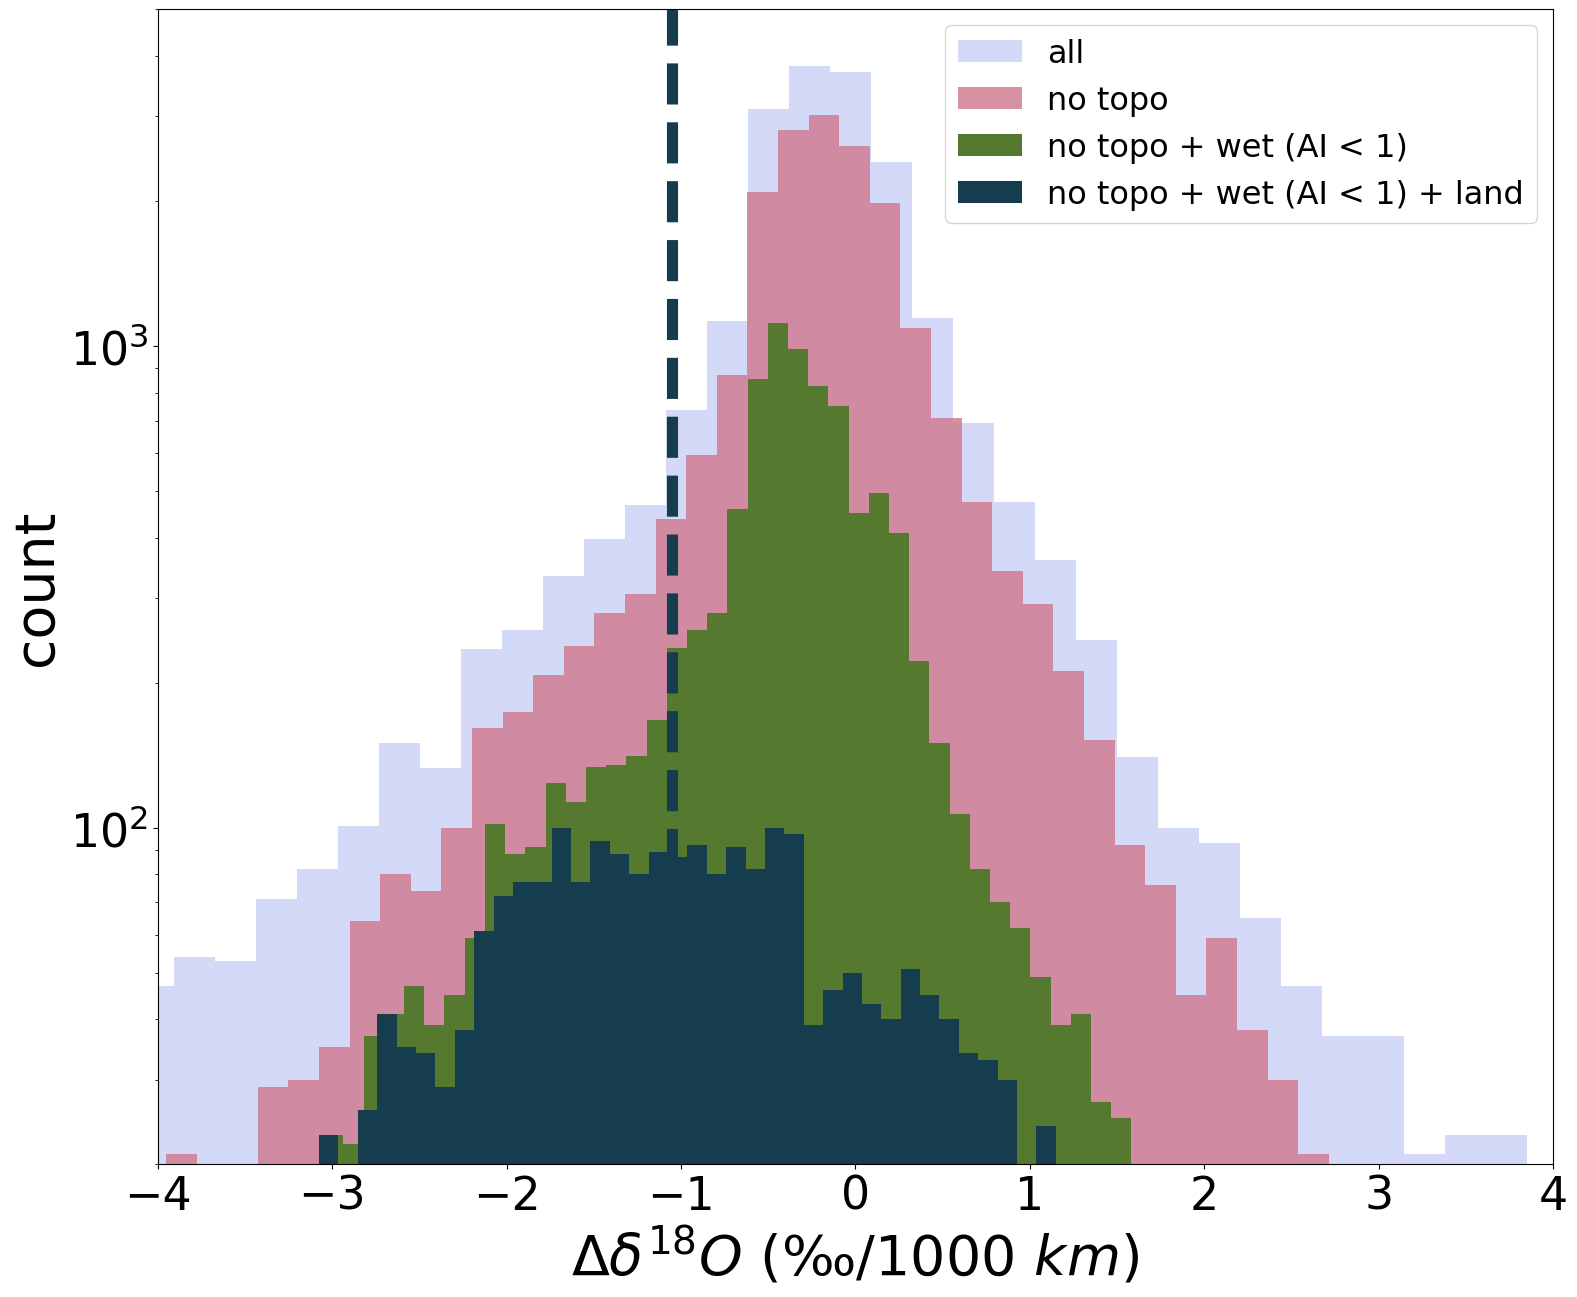

In [6]:
# --- 
fname = "iCESM_annPrWtd_gradient_hist.png"
# --- pull out yr_slice dat
ds_slc = ds.sel(yr_slice=this_slice, lat=slice(minlat,maxlat)).copy()
# annual breakdowns
pvar0 = ds_slc[Dd18_var].values.flatten()  # all data
tds_topo = ds_slc.where(ds_slc[Dtopo_var] < hatch_above)  # ltopo limit
pvar1 = tds_topo[Dd18_var].values.flatten()  # topo limit
pvar2 = tds_topo.where(tds_topo['Pmin1300_mmyr'] > pminPET1300_threshold)[Dd18_var].values.flatten()  # precip limit and topo limit
tds = tds_topo.where(tds_topo['LANDFRAC']>0.7)  # land only
pvar3 = tds.where(tds['Pmin1300_mmyr'] > pminPET1300_threshold)[Dd18_var].values.flatten()  # precip limit and topo limit and land only

# --- summary statistics
median_darkgreen = np.nanmedian(pvar3)
mean_darkgreen = np.nanmean(pvar3)


# --- set colors
pal = sns.color_palette("cubehelix_r", 4)  # https://seaborn.pydata.org/tutorial/color_palettes.html 

# --- plot aes
xmin, xmax = -4, 4
# textsize, 
ylabsize=40
xlabsize=40
xticksize, yticksize = 33, 33


# --- PLOT ---------------------
spec = gridspec.GridSpec(ncols=1, nrows=1, hspace=0.15)
plt.figure(figsize=(18,15))

# --- annual
ax = plt.subplot(spec[0])
# vertical line for median 
plt.axvline(x=mean_darkgreen, linestyle='dashed', linewidth=8, color=pal[3])
plt.hist(pvar0, label="all", bins=100, alpha=0.7, color=pal[0])
plt.hist(pvar1, label="no topo", bins=100, alpha=0.85, color=pal[1])
plt.hist(pvar2, label="no topo + wet (AI < 1)", bins=100, alpha=1, color=pal[2])
plt.hist(pvar3, label="no topo + wet (AI < 1) + land", bins=100, alpha=1, color=pal[3])
plt.ylim(20, 5e3)
plt.xlabel(r'$\Delta\delta^{18}O \ \left(‰/1000 \ km\right)$', fontsize=ylabsize)
plt.xticks(fontsize=xticksize)
plt.xlim(xmin, xmax)
plt.ylabel(r'count', fontsize=ylabsize)
plt.yticks(fontsize=yticksize)
plt.yscale('log')
plt.legend(fontsize= 23);

# --- 
if figsave_on:
    plt.savefig(os.path.join(saveHere, fname), dpi=300, bbox_inches='tight', transparent=False)

In [15]:
median_darkgreen = np.nanmedian(pvar3)
mean_darkgreen = np.nanmean(pvar3)
mean_darkgreen

-1.052959248202408